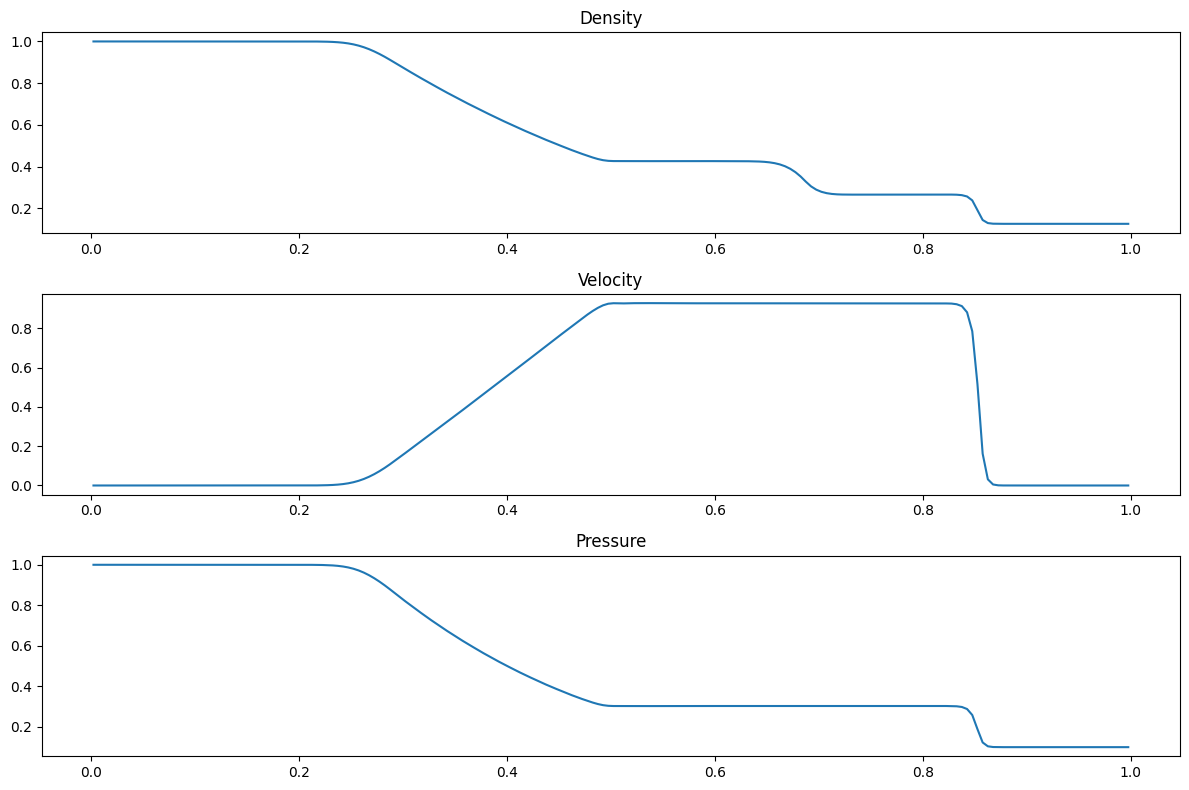

In [2]:
import numpy as np
import matplotlib.pyplot as plt

nx = 200          
dx = 1.0 / nx     
cfl = 0.5         
t_end = 0.2       
gamma = 1.4        

def initial_condition(x):
    rho = np.where(x < 0.5, 1.0, 0.125)
    u = np.zeros_like(x)
    p = np.where(x < 0.5, 1.0, 0.1)
    return rho, u, p

def minmod(a, b):
    return 0.5 * (np.sign(a) + np.sign(b)) * np.minimum(np.abs(a), np.abs(b))

def compute_flux(U_L, U_R, gamma):
    rho_L, u_L, p_L = U_L[0], U_L[1]/U_L[0], (gamma-1)*(U_L[2] - 0.5*U_L[1]**2/U_L[0])
    rho_R, u_R, p_R = U_R[0], U_R[1]/U_R[0], (gamma-1)*(U_R[2] - 0.5*U_R[1]**2/U_R[0])
    
    a_L = np.sqrt(gamma * p_L / rho_L)
    a_R = np.sqrt(gamma * p_R / rho_R)
    S_L = np.minimum(u_L - a_L, u_R - a_R)
    S_R = np.maximum(u_L + a_L, u_R + a_R)
    
    F_L = np.array([rho_L * u_L, rho_L * u_L**2 + p_L, u_L * (U_L[2] + p_L)])
    F_R = np.array([rho_R * u_R, rho_R * u_R**2 + p_R, u_R * (U_R[2] + p_R)])
    
    flux = np.zeros_like(F_L)
    for i in range(3):
        flux[i] = np.where(S_L >= 0, F_L[i], 
                          np.where(S_R <= 0, F_R[i], 
                                  (S_R*F_L[i] - S_L*F_R[i] + S_L*S_R*(U_R[i] - U_L[i])) / (S_R - S_L)))
    return flux


def tvd_rk3(U, dt, dx, gamma):
    L1 = compute_rhs(U, dx, gamma)
    U1 = U + dt * L1
    
    L2 = compute_rhs(U1, dx, gamma)
    U2 = 0.75*U + 0.25*(U1 + dt*L2)
    
    L3 = compute_rhs(U2, dx, gamma)
    U_new = (U + 2*(U2 + dt*L3)) / 3
    
    return U_new

def compute_rhs(U, dx, gamma):
    U_ext = np.zeros((3, U.shape[1] + 2))
    U_ext[:, 1:-1] = U
    U_ext[:, 0] = U[:, 0]
    U_ext[:, -1] = U[:, -1]
    
    slope = np.zeros_like(U_ext)
    for i in range(3):
        slope[i, 1:-1] = minmod(U_ext[i, 2:] - U_ext[i, 1:-1], 
                               U_ext[i, 1:-1] - U_ext[i, :-2])
    
    U_L = U_ext[:, :-1] + 0.5 * slope[:, :-1]
    U_R = U_ext[:, 1:] - 0.5 * slope[:, 1:]
    
    flux = np.zeros((3, U.shape[1]+1))
    for j in range(U.shape[1]+1):
        flux[:, j] = compute_flux(U_L[:, j], U_R[:, j], gamma)
    
    rhs = (flux[:, :-1] - flux[:, 1:]) / dx
    return rhs

def main():
    
    x = np.linspace(0.5*dx, 1.0 - 0.5*dx, nx)
    rho, u, p = initial_condition(x)
    E = p / (gamma-1) + 0.5 * rho * u**2
    U = np.array([rho, rho*u, E])
    
    
    t = 0.0
    while t < t_end:
        
        a = np.sqrt(gamma * p / rho)
        dt = cfl * dx / (np.max(np.abs(u) + a))
        if t + dt > t_end:
            dt = t_end - t
        
        U = tvd_rk3(U, dt, dx, gamma)
        t += dt
        
        rho, u, p = U[0], U[1]/U[0], (gamma-1)*(U[2] - 0.5*U[1]**2/U[0])
    

    plt.figure(figsize=(12,8))
    plt.subplot(311)
    plt.plot(x, rho)
    plt.title('Density')
    plt.subplot(312)
    plt.plot(x, u)
    plt.title('Velocity')
    plt.subplot(313)
    plt.plot(x, p)
    plt.title('Pressure')
    plt.tight_layout()
    plt.savefig("TVD.jpg",dpi=600,bbox_inches='tight')

if __name__ == '__main__':
    main()